In [1]:
%load_ext autoreload
%autoreload 2

from PDE import Projectile2D

In [2]:
model = Projectile2D()

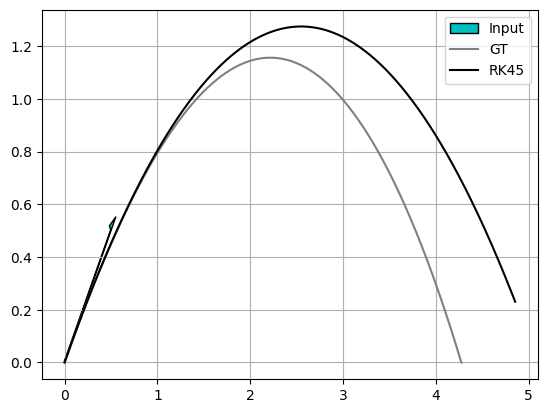

In [3]:
model.show_simulate([5., 5.])

In [18]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

networks = Sequential()

networks.add(Dense(32, activation='tanh', input_shape=(model.num_u+1,))) 
networks.add(Dense(32, activation='tanh'))
networks.add(Dense(model.num_s, activation='linear'))

networks.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                128       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 1,250
Trainable params: 1,250
Non-trainable params: 0
_________________________________________________________________


In [31]:
class PINNs(tf.keras.Model):
    def __init__(self, networks):
        super().__init__(self)
        self.networks = networks
        
    def call(self, x):
        with tf.GradientTape() as tape1:
            tape1.watch(x)
            with tf.GradientTape() as tape2:
                tape2.watch(x)
                s = self.networks(x)
            ds_dt = tape2.batch_jacobian(s, x)[..., -1]
        d2s_dt2 = tape1.batch_jacobian(ds_dt, x)[..., -1]
        
        return s, ds_dt, d2s_dt2


pinns = PINNs(networks)

x = tf.Variable([[2., 4., 3.]])

s, ds_dt, d2s_dt2 = pinns(x)

print(s, ds_dt, d2s_dt2)

tf.Tensor([[ 2.4917943  -0.21352574]], shape=(1, 2), dtype=float32) tf.Tensor([[0.44260442 0.0256418 ]], shape=(1, 2), dtype=float32) tf.Tensor([[-0.11033438 -0.04473524]], shape=(1, 2), dtype=float32)


In [32]:
from tensorflow.keras.losses import MeanSquaredError
loss_f = MeanSquaredError()

def get_ic_loss(inputs, outputs):
    s, ds_dt, d2s_dt2 = outputs
    x = s[..., :1]
    y = s[..., 1:]
    
    dx_dt = ds_dt[..., :1]
    dy_dt = ds_dt[..., 1:]
    
    x_loss = loss_f(tf.zeros_like(x), x)
    y_loss = loss_f(tf.zeros_like(y), y)
    
    vx_loss = loss_f(inputs[..., 0:1], dx_dt)
    vy_loss = loss_f(inputs[..., 1:2], dy_dt)
    
    return [x_loss, y_loss, vx_loss, vy_loss]

def get_pde_loss(inputs, outputs):
    s, ds_dt, d2s_dt2 = outputs
    
    dx2_dt2 = d2s_dt2[..., :1]
    dy2_dt2 = d2s_dt2[..., 1:]
    
    ax_loss = loss_f(tf.zeros_like(dx2_dt2), dx2_dt2)
    ay_loss = loss_f(tf.ones_like(dy2_dt2)*-9.81, dy2_dt2)
    
    return [ax_loss, ay_loss]
    


In [33]:
import numpy as np
def get_lossNgrad(pinns):
    batch_ic = 100
    batch_pde = 10000
    losses = []
    
    with tf.GradientTape() as tape0:
        tape0.watch(pinns.networks.trainable_variables)
    
        # initial contidion
        ## get input data
        ic_u = tf.ones((batch_ic, 2)) * 5.
        ic_t = tf.zeros((batch_ic, 1))
        ic_inputs = tf.concat([ic_u, ic_t], axis=-1)
        ## feed forward
        ic_outputs = pinns(ic_inputs)
        ## get loss
        ic_loss = get_ic_loss(ic_inputs, ic_outputs)
        losses += ic_loss
        
        
        # partial differential equation
        ## get input data
        pde_u = tf.ones((batch_pde, 2)) * 5.
        pde_t = np.random.rand(batch_pde, 1)
        pde_inputs = tf.concat([pde_u, pde_t], axis=-1)
        ## feed forward
        pde_outputs = pinns(pde_inputs)
        ## get loss
        pde_loss = get_pde_loss(pde_inputs, pde_outputs)
        losses += pde_loss
        
        
        # get total loss
        total_loss = tf.reduce_mean(losses)
        
    gradients = tape0.gradient(total_loss, pinns.networks.trainable_variables)
    
    return total_loss, gradients

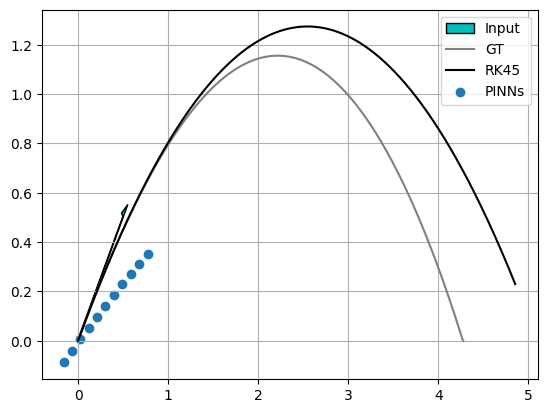

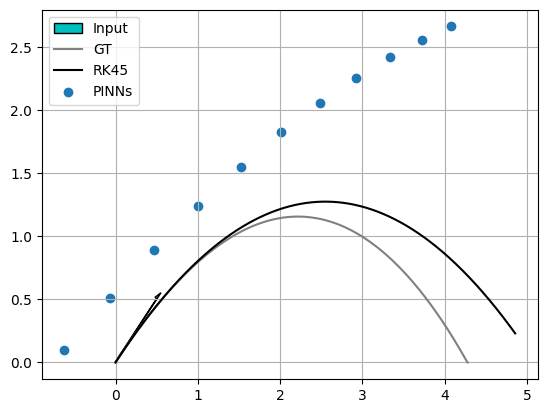

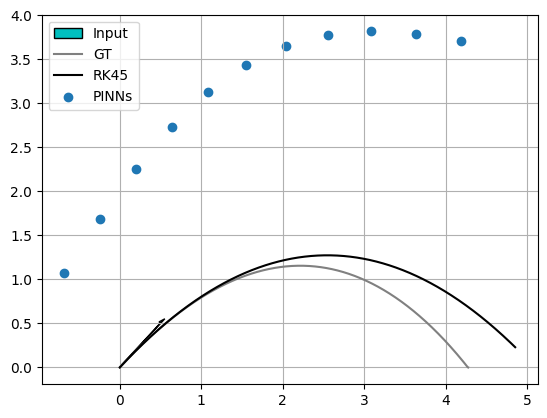

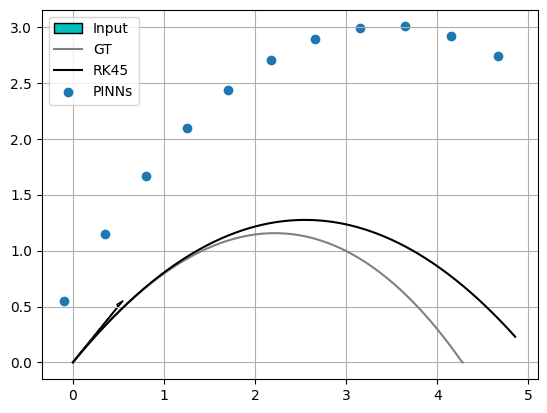

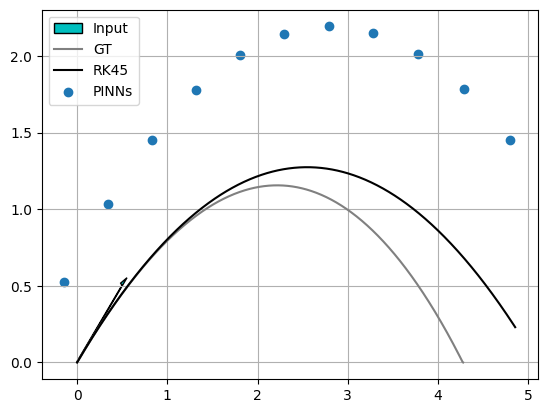

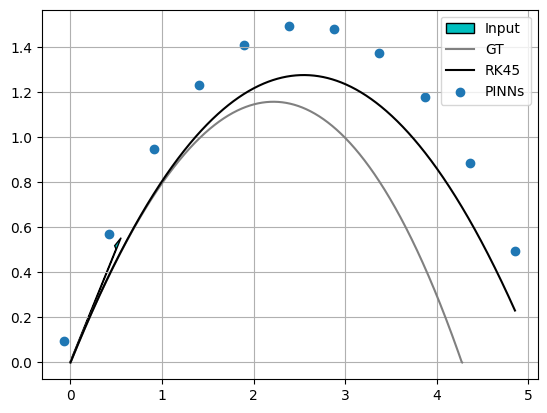

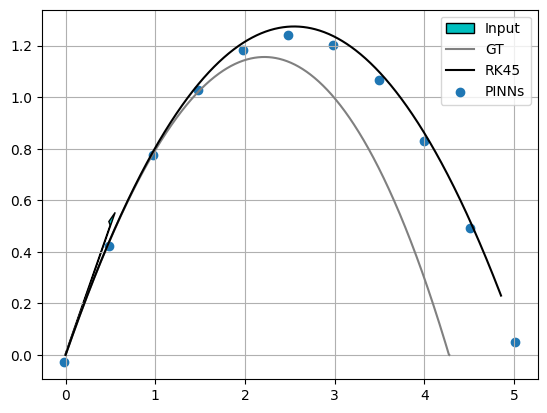

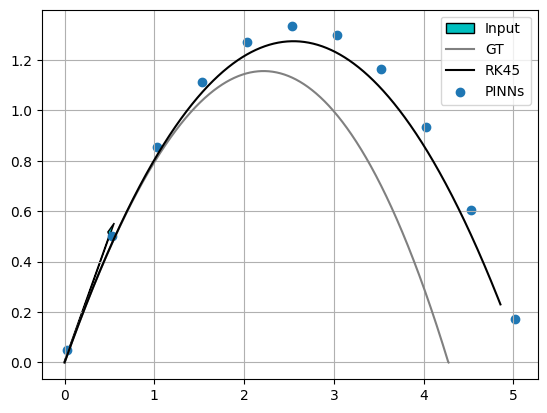

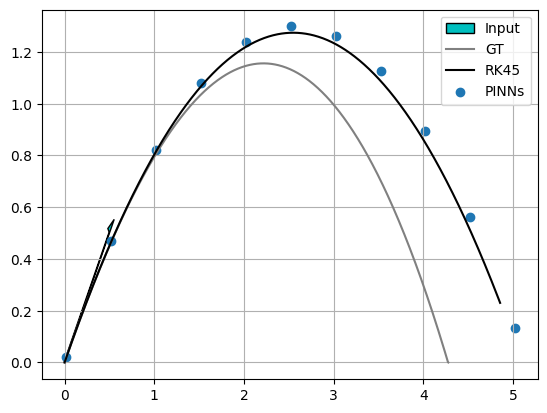

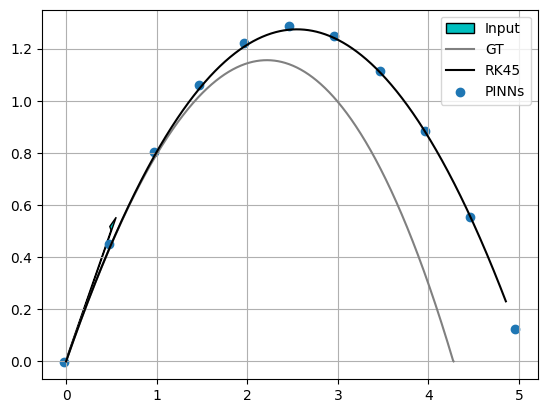

In [35]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-2)
num_epochs = 100

for e in range(num_epochs):
    
    loss, gradients = get_lossNgrad(pinns)
    optimizer.apply_gradients(zip(gradients, pinns.networks.trainable_variables))
    
    print(f"Epoch {e+1}: total_loss={loss:.3f}", end='\r')
    
    if e % 10 == 0:
        model.show_networks([5., 5.], pinns.networks)
    
    if loss < 0.0:
        optimizer = Adam(learning_rate=1e-3)
    

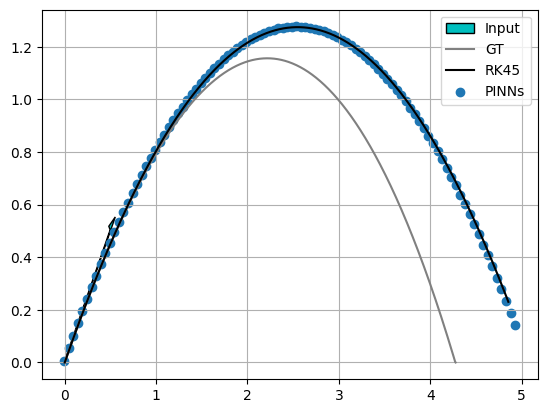

In [36]:
model.show_networks([5., 5.], pinns.networks, ts=[t*0.01 for t in range(0, 100, 1)])

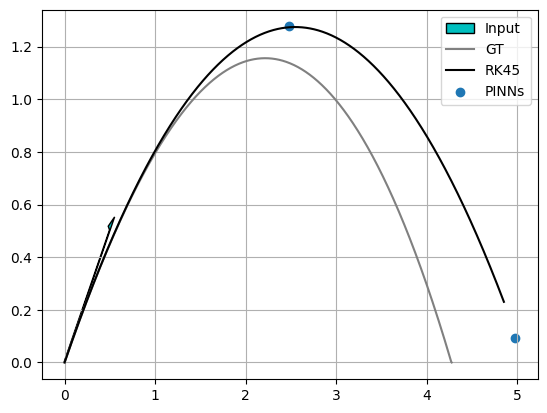

In [38]:
model.show_networks([5., 5.], networks, ts=[0.5, 1.0])

In [39]:
from data import DataLoader
data_loader = DataLoader(physics_model=model)

num_measure = 50
data_t, data_x = data_loader.get_data_points(num_measure)
print(data_t.shape, data_x.shape)

(50, 1) (50, 1)


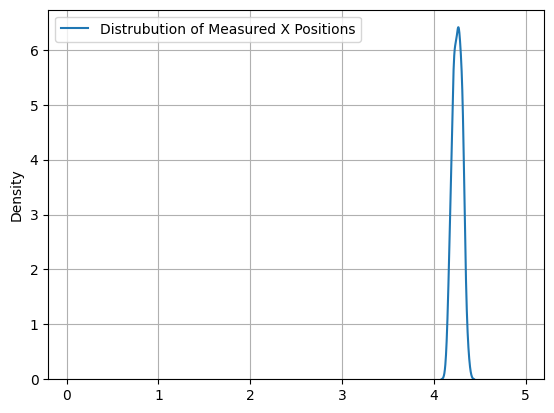

In [40]:
model.show_measure(data_x)

In [24]:
network = Sequential()

network.add(Dense(32, activation='tanh', input_shape=(model.num_u+1,))) 
network.add(Dense(32, activation='tanh'))
network.add(Dense(model.num_s, activation='linear'))

pinns_data = PINNs(network)

In [43]:
def get_data_loss(inputs, outputs, true_x):
    s, ds_dt, d2s_dt2 = outputs
    x = s[..., :1]
    y = s[..., 1:]
    
    x_loss = loss_f(true_x, x)
    y_loss = loss_f(tf.zeros_like(y), y)
    
    return [x_loss, y_loss]

In [44]:
import numpy as np
def get_lossNgrad(pinns):
    batch_ic = 100
    batch_pde = 10000
    batch_data = 50
    losses = []
    
    with tf.GradientTape() as tape0:
        tape0.watch(pinns.networks.trainable_variables)
    
        # initial contidion
        ## get input data
        ic_u = tf.ones((batch_ic, 2)) * 5.
        ic_t = tf.zeros((batch_ic, 1))
        ic_inputs = tf.concat([ic_u, ic_t], axis=-1)
        ## feed forward
        ic_outputs = pinns(ic_inputs)
        ## get loss
        ic_loss = get_ic_loss(ic_inputs, ic_outputs)
        losses += ic_loss
        
        
        # partial differential equation
        ## get input data
        pde_u = tf.ones((batch_pde, 2)) * 5.
        pde_t = np.random.rand(batch_pde, 1)
        pde_inputs = tf.concat([pde_u, pde_t], axis=-1)
        ## feed forward
        pde_outputs = pinns(pde_inputs)
        ## get loss
        pde_loss = get_pde_loss(pde_inputs, pde_outputs)
        losses += pde_loss
        
        
        # data
        ## get input data
        data_u = tf.ones((batch_data, 2)) * 5.
        data_inputs = tf.concat([data_u, data_t], axis=-1)
        ## feed forward
        data_outputs = pinns(data_inputs)
        ## get loss
        data_loss = get_data_loss(data_inputs, data_outputs, data_x)
        losses += data_loss
        
        
        # get total loss
        total_loss = tf.reduce_mean(losses)
        
    gradients = tape0.gradient(total_loss, pinns.networks.trainable_variables)
    
    return total_loss, gradients

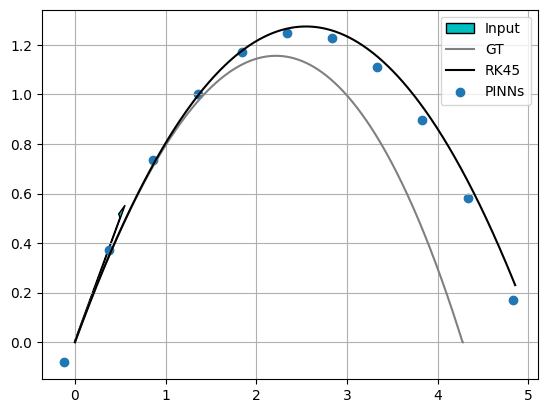

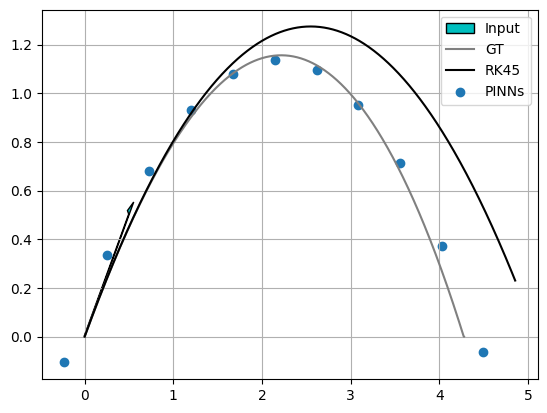

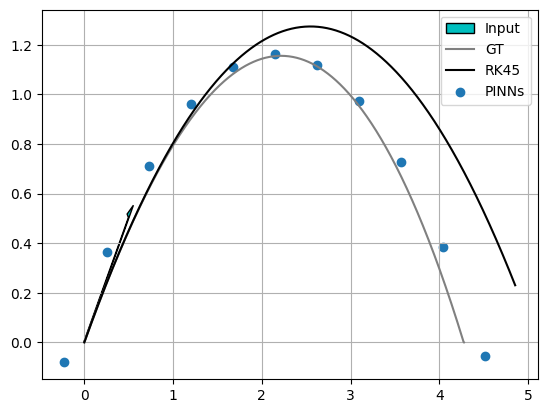

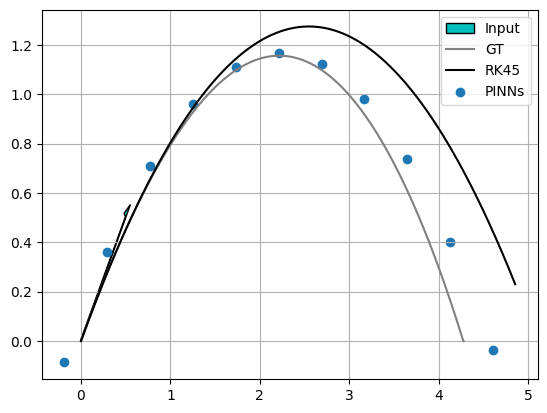

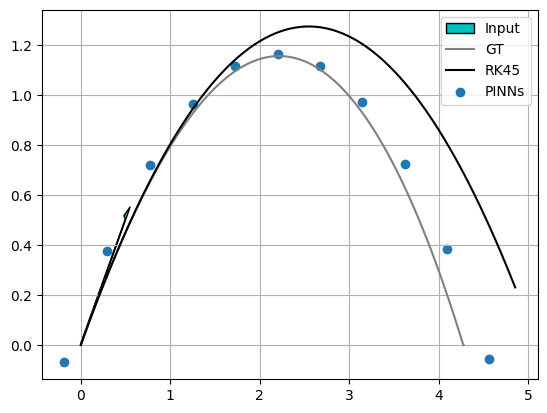

In [45]:
optimizer = Adam(learning_rate=1e-3)
num_epochs = 50

for e in range(num_epochs):
    
    loss, gradients = get_lossNgrad(pinns)
    optimizer.apply_gradients(zip(gradients, pinns.networks.trainable_variables))
    
    print(f"Epoch {e+1}: total_loss={loss:.3f}", end='\r')
    
    if e % 10 == 0:
        model.show_networks([5., 5.], pinns.networks)

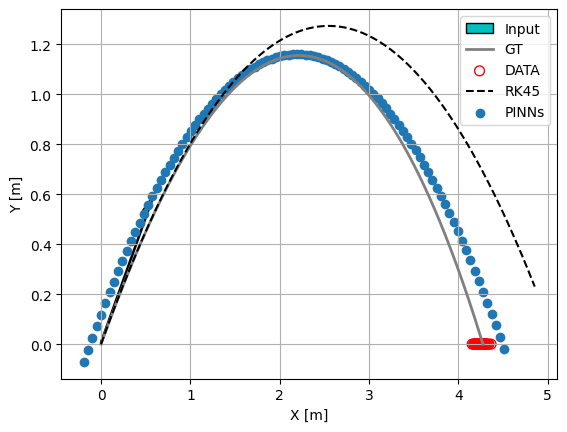

In [61]:
model.show_networks([5., 5.], pinns.networks, 
                    ts=[t*0.01 for t in range(0, 100, 1)],
                    data=data_x,
                    )